In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import multinomial, mode
from scipy import stats
from scipy.linalg.blas import dtrmm
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.metrics import roc_auc_score, accuracy_score
 
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
#from matplotlib2tikz import save as tikz_save
 
from importlib import reload
#import random
#random.seed(100)
 
import tensorflow as tf
from scipy.io import loadmat, savemat
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
def data_partitionMA(X,Y,t,ind,frac,seed):
  import math
  """ Function to partition data into train, test
  ind  --> matrix with shufled index (w,N) where w are the different possible random states
  frac --> fraction of data for training
  seed --> fixed random state for reproducibility
  """
  N = X.shape[0]
  Xtrain = X[ind[seed][:math.ceil(N*frac)]]
  Ytrain = Y[ind[seed][:math.ceil(N*frac)]]
  ttrain = t[ind[seed][:math.ceil(N*frac)]]

  Xtest = X[ind[seed][math.ceil(N*frac):]]
  Ytest = Y[ind[seed][math.ceil(N*frac):]]
  ttest = t[ind[seed][math.ceil(N*frac):]]

  return Xtrain, Ytrain, ttrain, Xtest, Ytest, ttest

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def bin_Y(Y):
  aux = np.unique(Y)
  aux = aux[aux>-1]
  N = Y.shape[0] 
  K = len(aux)
  R = Y.shape[1]
  Ynew = np.zeros([N,K,R])

  for r in range(R):
    aux = Y[:,r]
    for k in range(K):
      if K==2:
        Ynew[:,k,r] = (aux==k).astype(np.int)
      else:
        Ynew[:,k,r] = (aux==k+1).astype(np.int)

  return Ynew


# Define custom loss
def custom_loss(K,R):
  #pi [N,R]

  #@tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
  # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
  def max_like(y_true, y_pred): # y_true [batch_size, K, R]
    #kernels###############################################
    N = y_true.shape[0]
    #K = y_pred[:, R:].shape[1]
    #K = np.unique(y_true).size
    y_hat = tf.repeat(tf.expand_dims(y_pred[:, :K],-1), R, axis = -1)

    pi = y_pred[:, K:]

    p_logreg = tf.math.reduce_prod(tf.math.pow(y_hat, y_true), axis=1)

    temp1 = pi*p_logreg           
    temp2 = (1-pi)/K
    Zp = temp1/tf.math.add(temp1,temp2)
      
    #Likelihood 

    temp1 = Zp*tf.math.log(pi*p_logreg)       
    temp2 = (1-Zp)*tf.math.log((1-pi)*1/K)   

    #####funcion de costo############################################
    f = -tf.math.reduce_sum(tf.math.add(temp1,temp2))
    return f
  
  # Return a function
  return max_like

def custom_loss2(K,R):
  #pi [N,R]

  #@tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
  # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
  def max_like(y_true, y_pred): # y_true [batch_size, K, R]
    #kernels###############################################
    N = y_true.shape[0]
    #K = y_pred[:, R:].shape[1]
    #K = np.unique(y_true).size
    y_hat = tf.repeat(tf.expand_dims(y_pred[:, :K],-1), R, axis = -1)

    Z = y_pred[:, K:]
    p_logreg = tf.math.reduce_prod(tf.math.pow(y_hat, y_true), axis=1)

   #temp1 = Z*p_logreg           
    #temp2 = (1-Z)/K
      
    #Likelihood 

    temp1 = Z*tf.math.log(p_logreg)       
    temp2 = (1-Z)*tf.math.log(1/K)   

    #####funcion de costo############################################
    f = -tf.math.reduce_sum(tf.math.add(temp1,temp2))
    return f
  
  # Return a function
  return max_like

def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler


def scheduler2(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.01)


class Keras_MA_pi_kern(BaseEstimator, TransformerMixin):
  def __init__(self, K, R, P, w_init='PCA', epochs=30,batch_size=64,learning_rate=1e-3,optimizer='RMS',
               validation_split=0.3, verbose=1, ratio=1.2, scale=0.1, seed=None, ratio_lin=0.75,
               l1=0.01, l2=0.01, RBFout=100, dropout=True, BN=True):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.ratio = ratio
        self.K = K
        self.R = R
        self.P = P
        self.scale = scale
        self.l1 = l1
        self.l2 = l2
        self.w_init = w_init
        self.seed = seed
        self.RBFout = RBFout
        self.ratio_lin = ratio_lin
        self.dropout = dropout
        self.BN = BN

        
  def fit(self, X, t):
    #lb = LabelBinarizer()
    #lb.fit(X[:,-1])
    #N = X.shape[0]
    #y = np.zeros([N, self.K, self.R])
    #for i in range(N):
    #  y[i,:,:] = binarize(X[i,self.P:],lb).T
    y2 = X[:,self.P:]
    y = bin_Y(y2)

    Xt = X[:,:self.P]
    if self.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    elif self.optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
    elif self.optimizer == "RMS":
        opt = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
    else:
        opt=self.optimizer

    
    ###acomodar arquitectura de red###### 
    tf.keras.backend.clear_session()

    inputA = tf.keras.layers.Input(shape=(Xt.shape[1]), name='entradaA')
    #if self.dropout:
    #  inputA = tf.keras.layers.AlphaDropout(rate=0.2)(inputA)

    Q1 = self.K ## num clases
    Q2 = self.R ## num anotadores
    Q3 = int(self.ratio_lin*self.P)#self.ratio_lin

    initializer = tf.keras.initializers.GlorotNormal(seed=self.seed)

    if self.w_init == 'PCA':
      pca = PCA().fit(Xt).components_
      initializer1 = tf.keras.initializers.Constant(value=pca[:Q3,:].T)
    elif self.w_init == 'inv':
      enc = OneHotEncoder()
      ymv = mode(y2,1)[0]
      yb = enc.fit_transform(ymv).toarray()
      Q3 = self.K
      w_init = np.linalg.pinv(Xt).dot(yb)
      initializer1 = tf.keras.initializers.Constant(value=w_init)
    else:
      initializer1 = initializer

    hW1 = tf.keras.layers.Dense(Q3,activation='linear',name='W',  bias_initializer='zeros', kernel_initializer=initializer1,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1,l2=self.l2))(inputA)
    if self.BN:
      hW1 = tf.keras.layers.BatchNormalization()(hW1)
    if self.dropout:
      hW1 = tf.keras.layers.AlphaDropout(rate=0.2)(hW1)

    hW1_1 = tf.keras.layers.Dense(self.RBFout,activation='tanh',name='W2',  bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1,l2=self.l2))(hW1)                         
    if self.BN:
      hW1_1 = tf.keras.layers.BatchNormalization()(hW1_1)
    if self.dropout:
      hW1_1 = tf.keras.layers.AlphaDropout(rate=0.2)(hW1_1)
    #hW1_1 = tf.keras.layers.experimental.RandomFourierFeatures(output_dim=self.RBFout, name='RBF', kernel_initializer='gaussian', scale=self.scale)(hW1)
    
    hW = tf.keras.layers.Dense(Q1,activation='softmax',name='Yhat',  bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1,l2=self.l2))(hW1_1)
    

    hW2 = tf.keras.layers.Dense(Q2,activation='sigmoid',name='PI', bias_initializer='zeros', kernel_initializer=initializer,
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1,l2=self.l2))(hW1_1)

    concAB = tf.keras.layers.concatenate([hW,hW2],name='concAB')

    self.model = tf.keras.Model(inputs=inputA, outputs=concAB)
    self.model.compile(loss=custom_loss2(K=self.K, R= self.R), 
              optimizer=opt) #f1, precision, recall, crossentropy
            

    callback1 = tf.keras.callbacks.TerminateOnNaN()
    callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = self.ratio))
    #callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
    callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                                 patience=15, verbose=0, mode="auto",
                                                 baseline=None, restore_best_weights=True)

    
    self.history = self.model.fit(x = Xt, y = y,
                        epochs=self.epochs,batch_size=self.batch_size,
                        validation_split=self.validation_split, 
                        callbacks = [callback1, callback2],# callback3], 
                        verbose = self.verbose)
    
  def predict(self, X, *_):
    pred = self.model.predict(X[:,:self.P])[:,:self.K]
    return np.argmax(pred, axis=1)
  
  def predict_proba(self, X, *_):
    pred = self.model.predict(X[:,:self.P])[:,:self.K]
    return pred

  def plot_history_loss(self):
      plt.plot(self.history.history['loss'],label='loss')
      #plt.plot(self.history.history['val_loss'],label='val_loss')
      plt.legend()
      return
  
  def score(self, X, t):
    accuracy = np.mean(self.predict(X)==t.T)

    try:
      auc = roc_auc_score(ook(t), self.predict_proba(X))
    except:
      auc = 0.5
    
    dist = accuracy + auc

    return dist


## Some useful functions

In [ ]:
def one_of_K(y, K):
    Yhat = np.ones((y.shape[0], K))
    for k in range(K):
        Yhat[:,k,None] = (y==k+1).astype(np.int)
    return Yhat

#Defining the Sigmoid function and Softmax function
def Sigmoid(f_r):
    lam_r = 1/(1 + np.exp(-f_r))
    return lam_r

def Softmax(A):
    num = np.exp(A)
    den = np.sum(num, 1)
    den = den[:,np.newaxis]
    zeta_k = num/den
    return zeta_k

def MAjVot(Y, K):
    N,R = Y.shape
    Yhat = np.zeros((N,1))
    for n in range(N):
        votes = np.zeros((K,1))
        for r in range(R):
            for k in range(K):
                if Y[n,r] == k+1:
                    votes[k] = votes[k]+1
        Yhat[n] = np.argmax(votes) + 1
    return Yhat
    

## 1. Multi-class classification problem definition 

We assume a 1D multi-class classification problem, where input features are given as $x \in [0, 1]$ and the outputs are generated as follows

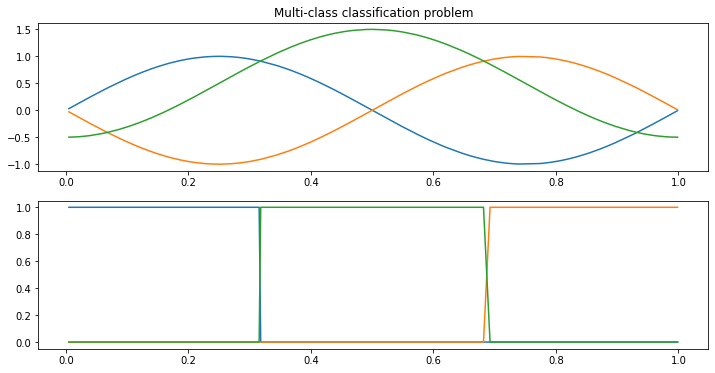

In [ ]:
N = 200
R = 5
seed = 0
np.random.seed(seed)
Ntest = 100

X = np.random.rand(N,1)

t1 = (np.sin(2*np.pi*X)).reshape(N,1)
t2 = (-np.sin(2*np.pi*X)).reshape(N,1)
t3 = (-np.sin(2*np.pi*(X+0.25))+0.5).reshape(N,1)
t = np.concatenate((t1, t2, t3), axis=1)

idx = np.argsort(X, axis=0).flatten()
X = X[idx]
t = t[idx,:]
y = np.array(np.argmax(t, 1).reshape(-1,1), dtype=float)+1
K = len(np.unique(y))

# The true labels in codification 1-of-K
Yhat = one_of_K(y, K)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(X, t)
plt.title('Multi-class classification problem')
plt.subplot(2,1,2)
plt.plot(X, Yhat)
plt.show()

To define the training set, we randomly obtain $N=100$ samples from the interval $[0, 1]$. Conversely, for the test set, we sample uniformly $200$ points from $[0, 1]$

In [ ]:
## Generación de as anotaciones múltiples moneda no homogénea

Pr = [[0,    0.9,  0.5, 0.15, 0.6 ],
     [0.9,   0,    0.3, 0.4,  0.75],
     [0.5,   0.3,  0,   0.6,  0.3 ],
     [0.15,  0.4,  0.6, 0,    0.8 ],
     [0.6,   0.75, 0.3, 0.8,  0   ]]

from scipy.stats import bernoulli
import random 

ls = []
lt = []

for q in range(R):
  for p in Pr[q]:
    ls = np.append(ls, bernoulli.rvs(1-p, size=int(N/5)))
  ls = ls[np.newaxis]
  if q==0:
    lt = ls
  else:
    lt = np.append(lt, ls, axis = 0)
  ls = []

yy=np.zeros([N,R])

for k in range(R):
  for i in range(N):
    if lt[k,i] == 1:
      yy[i,k] = y[i]

    else:
      if y[i] == 1:
        yy[i,k]= random.choice([2, 3])
      elif y[i] == 2:
        yy[i,k]= random.choice([1, 3])
      else:
        yy[i,k]= random.choice([1, 2])

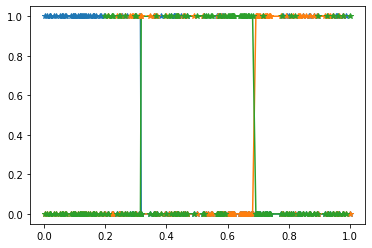

In [ ]:
plt.plot(X, Yhat)
plt.gca().set_prop_cycle(None)
plt.plot(X, one_of_K(yy[:,0][np.newaxis].T, K), '*')
plt.show()

In [ ]:
N_train = X.shape[0]
P = X.shape[1]

Xtest = np.linspace(0, 1, Ntest).reshape((Ntest,1))
t1 = (np.sin(2*np.pi*Xtest)).reshape(Ntest,1)
t2 = (-np.sin(2*np.pi*Xtest)).reshape(Ntest,1)
t3 = (-np.sin(2*np.pi*(Xtest+0.25))+0.5).reshape(Ntest,1)
ttest = np.concatenate((t1, t2, t3), axis=1)
ytest = np.array(np.argmax(ttest, 1).reshape(-1,1), dtype=float)+1

## Generación de as anotaciones múltiples moneda no homogénea

ls = []
lt = []

for q in range(R):
  for p in Pr[q]:
    ls = np.append(ls, bernoulli.rvs(1-p, size=int(Ntest/5)))
  ls = ls[np.newaxis]
  if q==0:
    lt = ls
  else:
    lt = np.append(lt, ls, axis = 0)
  ls = []

yytest=np.zeros([Ntest,R])

for k in range(R):
  for i in range(Ntest):
    if lt[k,i] == 1:
      yytest[i,k] = ytest[i]

    else:
      if y[i] == 1:
        yytest[i,k]= random.choice([2, 3])
      elif y[i] == 2:
        yytest[i,k]= random.choice([1, 3])
      else:
        yytest[i,k]= random.choice([1, 2])


In [ ]:
Xtrainf = np.concatenate((X, yy),1)
Xtestf = np.concatenate((Xtest, Xtest),1)

In [ ]:
mdl = Keras_MA_pi_kern(K=K, R=R, P=P, epochs=500, batch_size=N_train,#min(256, N_train), 
                        validation_split=0, learning_rate=0.01, ratio_lin=1,
                        ratio=1, verbose=0, scale=1, RBFout=K+R,
                        l1=0.001, l2=0.001, w_init='PCdA', seed=100, optimizer='RMS',
                        dropout=False, BN=False)

In [ ]:
mdl.fit(Xtrainf, y)

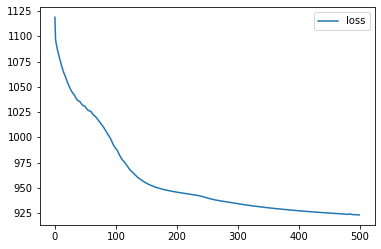

In [ ]:
mdl.plot_history_loss()

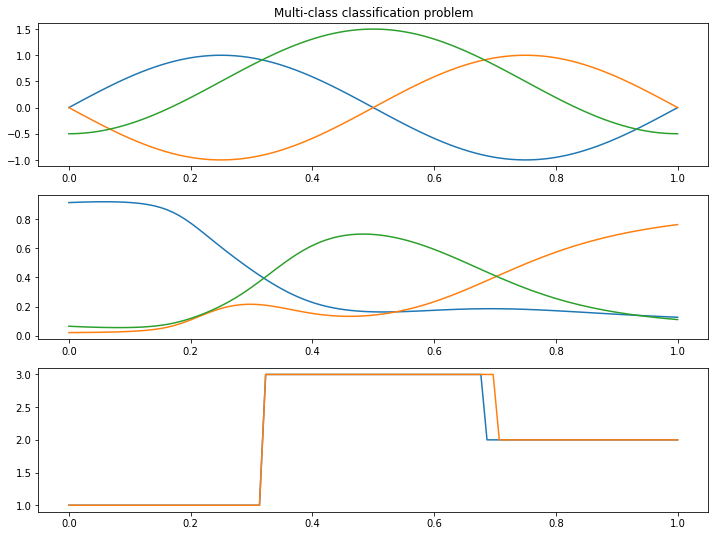

In [ ]:
plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.plot(Xtest, ttest)
plt.title('Multi-class classification problem')
plt.subplot(3,1,2)
plt.plot(Xtest, mdl.predict_proba(Xtest));
plt.subplot(3,1,3)
plt.plot(Xtest, ytest)
plt.plot(Xtest, mdl.predict(Xtest)+1)
plt.show()

In [ ]:
pi = mdl.model.predict(Xtestf[:,:P])[:,K:]

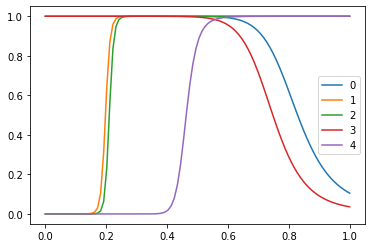

In [ ]:
plt.plot(Xtest, pi);
plt.legend(['0', '1', '2', '3','4']);

In [ ]:
pi_mean = np.asarray([[np.mean(pi[i:i+int(Ntest/R),k]) for i in range(0,Ntest,int(Ntest/R))] for k in range(R)])

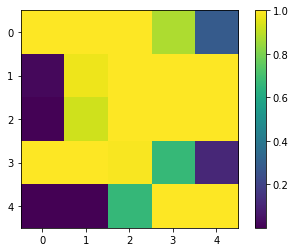

In [ ]:
plt.imshow(pi_mean);
plt.colorbar();

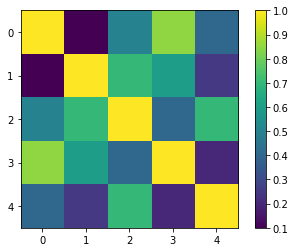

In [ ]:
pi_real = 1-np.asarray(Pr)
plt.imshow(pi_real);
plt.colorbar();

In [ ]:
np.append(pi_real[1,:][np.newaxis],pi_mean[1,:][np.newaxis],0)


array([[0.1       , 1.        , 0.7       , 0.6       , 0.25      ],
       [0.02308241, 0.97265851, 1.        , 1.        , 1.        ]])

In [ ]:
pi_c = np.zeros([10,5])
r=0
for i in range(0,10,2):
  pi_c[i:i+2, :] = np.append(pi_real[r,:][np.newaxis],pi_mean[r,:][np.newaxis],0)
  r=r+1

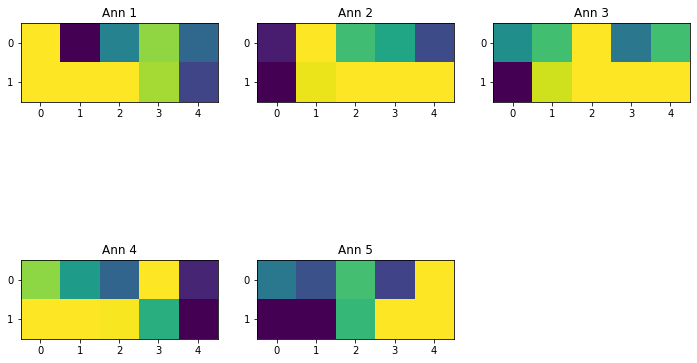

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.imshow(pi_c[[0,1],:]);

plt.title('Ann 1')
plt.subplot(2,3,2)
plt.imshow(pi_c[[2,3],:]);

plt.title('Ann 2')
plt.subplot(2,3,3)
plt.imshow(pi_c[[4,5],:]);

plt.title('Ann 3')
plt.subplot(2,3,4)
plt.imshow(pi_c[[6,7],:]);

plt.title('Ann 4')
plt.subplot(2,3,5)
plt.imshow(pi_c[[8,9],:]);
plt.title('Ann 5');

In [ ]:
pi_c.shape

(50,)